# QC + Doublet Finder

Basic QC. Find doublets per sample, visualize on overall UMAP and mark them.

Copy of `QC.ipynb` but performed on data with intronic reads counted.

In [1]:
library(Seurat)
library(dplyr)
library(ggplot2)
library(patchwork)
library(DoubletFinder)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [2]:
DAYS = c("D0", "D2", "D4", "D6", "D8", "D10", "D12", "D14", "iPSC")

In [3]:
day_config = read.table("../../figures_factory/configs/day.tsv", comment.char = '', header=T)
day_config$colour = as.character(day_config$colour)
day_config$day = factor(day_config$day, levels=DAYS)
rownames(day_config) = day_config$day
day_config

day  colour 
D0   D0   #A61C24
D2   D2   #FF70A6
D4   D4   #D6E82F
D6   D6   #B14AED
D8   D8   #2D3142
D10  D10  #FC7753
D12  D12  #0AABB7
D14  D14  #336699
iPSC iPSC #000000

## Load Data

In [4]:
# aggregated cellranger data
rna.data = Read10X("/srv/scratch/surag/scRNA-reprog/aggregate_w_intron/filtered_feature_bc_matrix")

In [5]:
rna = CreateSeuratObject(counts = rna.data, project = "scRNA-reprog", min.cells = 3, min.features = 200)

In [6]:
rna

An object of class Seurat 
32642 features across 89231 samples within 1 assay 
Active assay: RNA (32642 features, 0 variable features)

In [7]:
median(Matrix::colSums(rna@assays$RNA@counts))

[1] 14326

In [8]:
rownames(rna)[grep("lnc", rownames(rna), ignore.case = T)]

[1] "LNCTAM34A" "ERLNC1"    "THORLNC"   "LNCSRLR"   "LNCPRESS2" "FILNC1"   
 [7] "LNCPRESS1" "FLNC"      "FLNC-AS1"  "LNCOC1"    "LNCARSR"   "LNCAROD"  
[13] "LNCOG"     "ARLNC1"

In [9]:
rna[["sample"]] = DAYS[as.numeric(lapply(strsplit(colnames(rna), "-"), "[[", 2))]

In [10]:
head(rna@meta.data)

orig.ident   nCount_RNA nFeature_RNA sample
AAACCCAAGAGTGACC-1 scRNA-reprog 15040      4083         D0    
AAACCCAAGTGCCAGA-1 scRNA-reprog 14912      4444         D0    
AAACCCACAACTCGAT-1 scRNA-reprog 26047      5967         D0    
AAACCCACACCATTCC-1 scRNA-reprog 17516      5092         D0    
AAACCCACACGACAGA-1 scRNA-reprog 39128      7201         D0    
AAACCCACACGCGTCA-1 scRNA-reprog  9945      3421         D0

In [11]:
ncol(rna)

[1] 89231

In [12]:
table(rna@meta.data$sample)


   D0   D10   D12   D14    D2    D4    D6    D8  iPSC 
11679 13359  9793 10513  3852  7331 11234  7835 13635 

## Process

### QC Filters

In [13]:
rna[["percent.mt"]] = PercentageFeatureSet(rna, pattern="^MT-")
rna[["percent.oskm"]] = PercentageFeatureSet(rna, pattern="^(POU5F1|KLF4|MYC|SOX2)$")

In [14]:
quantile(rna@meta.data$nFeature_RNA, c(0, 0.1, 0.25, 0.5, 0.9, .99, 1))

0%     10%     25%     50%     90%     99%    100% 
  200.0   902.0  2866.0  4356.0  7167.0  9645.7 13492.0

In [15]:
quantile(rna@meta.data$nCount_RNA, c(0, 0.1, 0.25, 0.5, 0.9, .99, 1))

0%      10%      25%      50%      90%      99%     100% 
   500.0   2002.0   7024.0  14326.0  38254.0  85886.8 359095.0

In [16]:
quantile(rna@meta.data$percent.mt, c(0, 0.1, 0.25, 0.5, 0.9, .99, 1))

0%       10%       25%       50%       90%       99%      100% 
 0.000000  2.825913  4.397952  5.883297 16.447586 87.772021 96.754717

In [17]:
quantile(rna@meta.data$percent.oskm, c(0, 0.1, 0.25, 0.5, 0.9, .99, 1))

0%         10%         25%         50%         90%         99% 
 0.00000000  0.00000000  0.01776357  0.10854212  0.37459144  3.62496535 
       100% 
95.06512301

In [18]:
quantile(rna@meta.data$percent.oskm[rna$sample=="D2"], c(0, 0.1, 0.25, 0.5, 0.9, .95, .99, 1))

0%         10%         25%         50%         90%         95% 
 0.00000000  0.07681956  0.16814758  0.43478928 11.54546815 43.11035297 
        99%        100% 
88.03404635 94.57058735

In [19]:
qc_plot <- function(df, xlab, ylab, xline, yline, base_size=18) {
    ggplot(df, aes(x=x,y=y)) +
    stat_binhex(aes(fill=log10(1+..count..)), bins=100) +
    scale_fill_viridis_c() +
    xlab(xlab) + ylab(ylab) +
    geom_vline(xintercept = xline, col='red') + 
    geom_hline(yintercept = yline, col='red') +
    theme_bw(base_size=base_size)
}

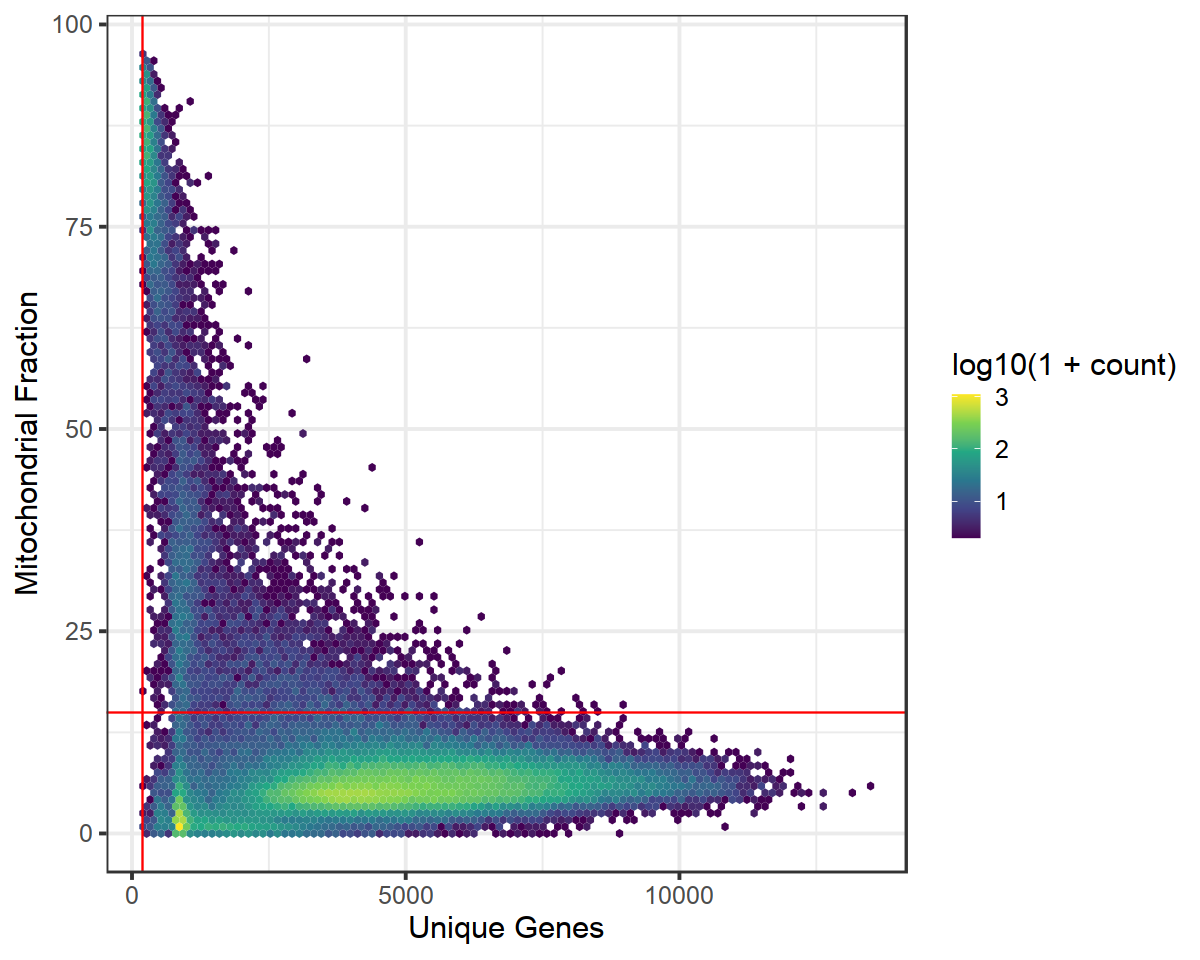

In [20]:
options(repr.plot.width = 10, repr.plot.height = 8)
qc_plot(data.frame(
    x=rna@meta.data$nFeature_RNA,
    y=rna@meta.data$percent.mt), 
        "Unique Genes", 
        "Mitochondrial Fraction",
       200, 15)

In [21]:
mt_vs_log_ct = list()

i=1
for (x in DAYS) {
   mt_vs_log_ct[[i]] = qc_plot(data.frame(
       x=log10(rna$nCount_RNA[rna$sample==x]),
       y=rna$percent.mt[rna$sample==x]), 
       "Log Counts", 
       "Mitochondrial Fraction",
       log10(2000), 15,
                               base_size=24) + 
    ggtitle(x) +
    xlim(c(2.5,5.5)) +
    ylim(c(-1,101)) +
    theme(plot.title = element_text(hjust = 0.5, size=28),
         legend.position = "none")
    
    i = i + 1
}

mt_vs_log_ct[[i]] = cowplot::get_legend(mt_vs_log_ct[[i-1]] + 
                                        theme(legend.position="right", 
                                              legend.key.width = unit(2, "cm"),
                                             legend.key.height = unit(1, "cm")) +
                                       scale_fill_viridis_c(name="Log Density",
                                                            labels=c()))

all_mt_vs_log_ct = wrap_plots(mt_vs_log_ct, nrow = 2)

Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.



Warning message:
“Removed 1 rows containing non-finite values (stat_binhex).”


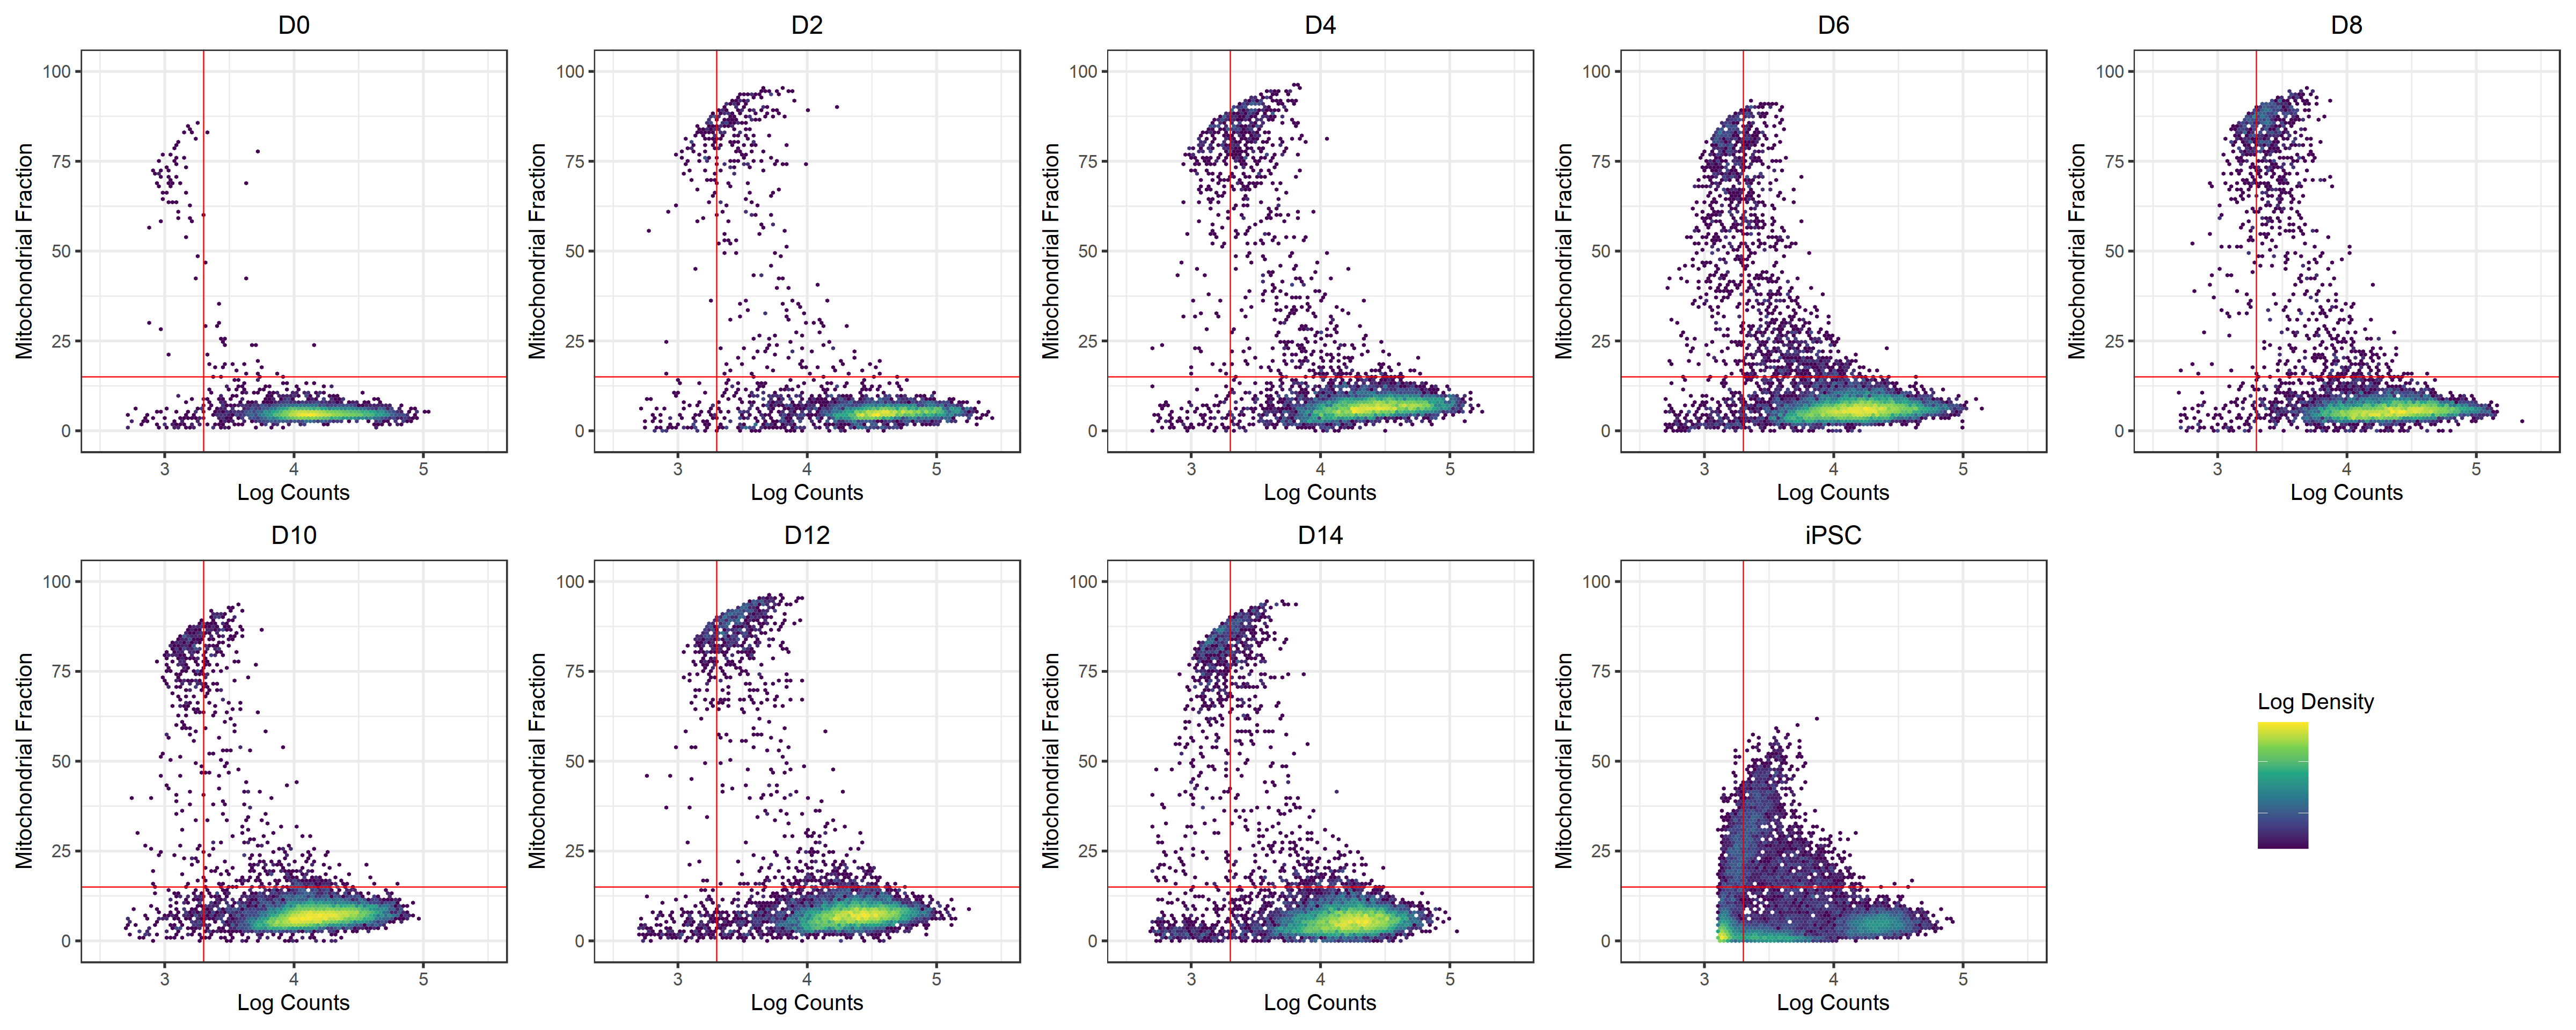

In [22]:
options(repr.plot.width = 40, repr.plot.height = 16)
all_mt_vs_log_ct

In [243]:
# ggsave("./QC_plots/20210722_QC.pdf", all_mt_vs_log_ct, height=16, width=40)

Warning message:
“Removed 1 rows containing non-finite values (stat_binhex).”


In [24]:
rev(sort(table(rna$sample[rna$percent.oskm>50])))
rev(sort(table(rna$sample[rna$percent.oskm>10])))


 D2  D4  D6  D8 
163  41   9   2 


 D2  D4  D6  D8 D14 D12 D10  D0 
402 148  30  14   1   1   1   1 

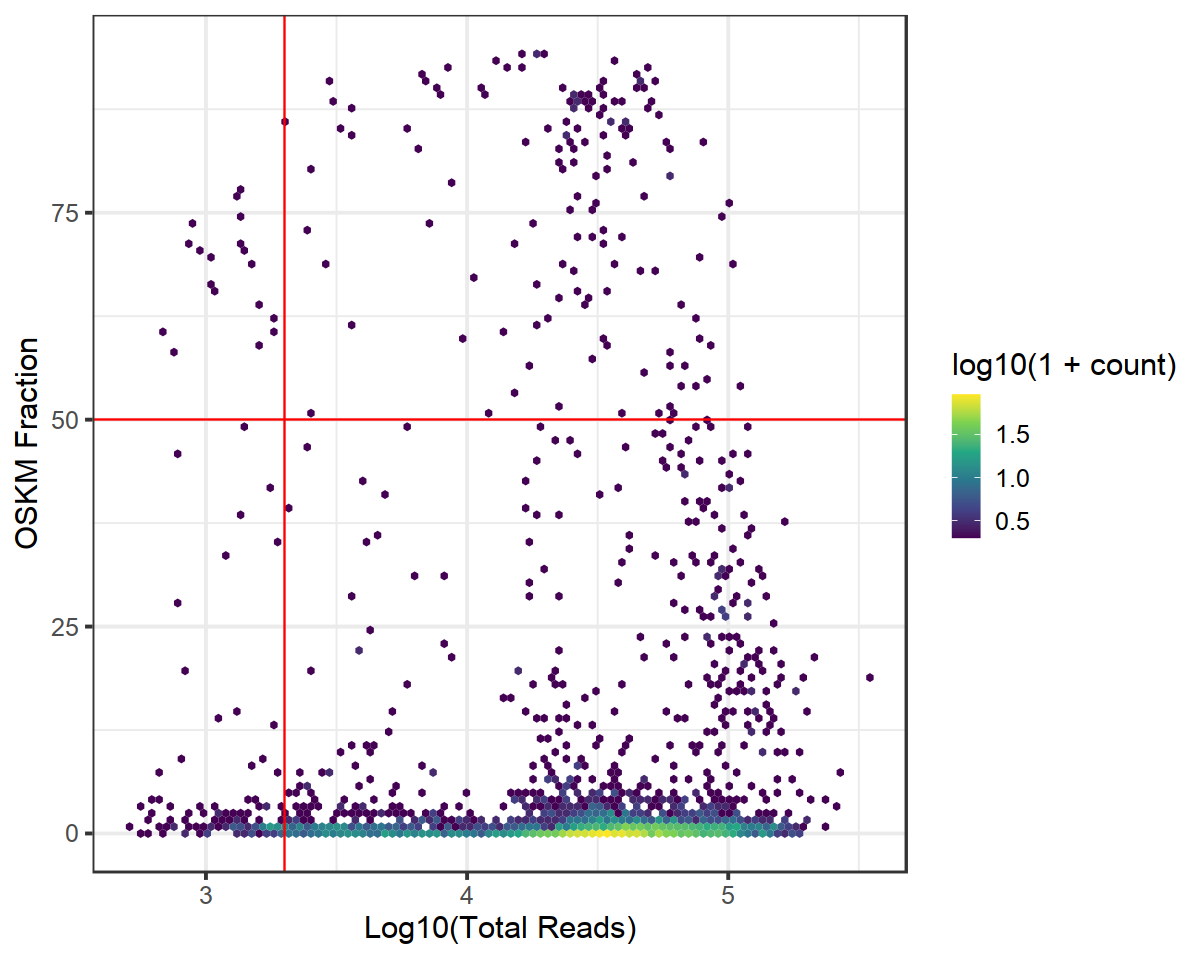

In [25]:
options(repr.plot.width = 10, repr.plot.height = 8)
qc_plot(data.frame(
    x=log10(rna$nCount_RNA[rna$sample=="D2"]),
    y=rna$percent.oskm[rna$sample=="D2"]), 
        "Log10(Total Reads)", 
        "OSKM Fraction",
       log10(2000), 50)

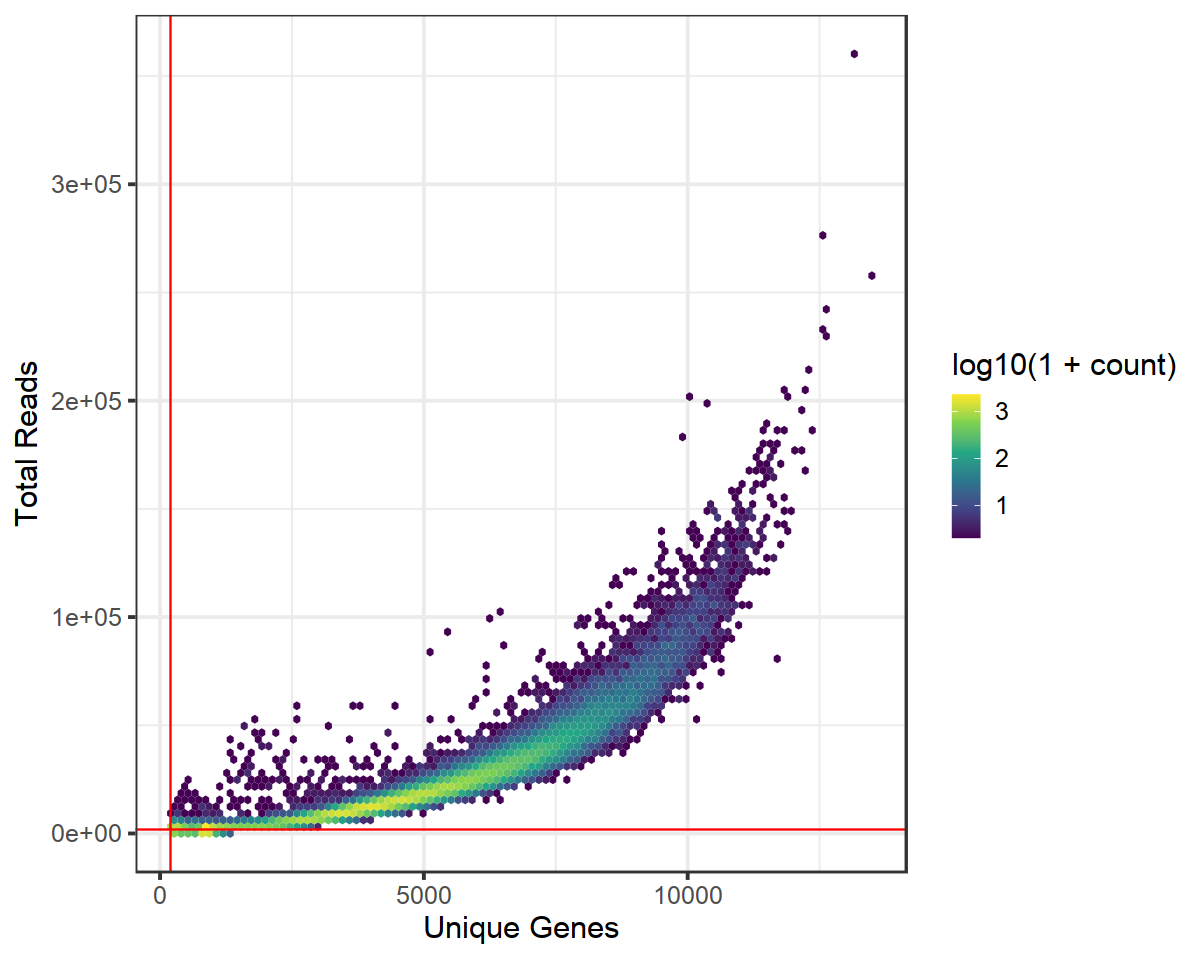

In [26]:
options(repr.plot.width = 10, repr.plot.height = 8)
qc_plot(data.frame(x=rna@meta.data$nFeature_RNA,
                   y=rna@meta.data$nCount_RNA),
        "Unique Genes", "Total Reads",
       200,2000)

In [27]:
head(rna@meta.data)

orig.ident   nCount_RNA nFeature_RNA sample percent.mt
AAACCCAAGAGTGACC-1 scRNA-reprog 15040      4083         D0     4.168883  
AAACCCAAGTGCCAGA-1 scRNA-reprog 14912      4444         D0     5.036212  
AAACCCACAACTCGAT-1 scRNA-reprog 26047      5967         D0     4.303759  
AAACCCACACCATTCC-1 scRNA-reprog 17516      5092         D0     3.670929  
AAACCCACACGACAGA-1 scRNA-reprog 39128      7201         D0     4.053363  
AAACCCACACGCGTCA-1 scRNA-reprog  9945      3421         D0     4.625440  
                   percent.oskm
AAACCCAAGAGTGACC-1 0.006648936 
AAACCCAAGTGCCAGA-1 0.013412017 
AAACCCACAACTCGAT-1 0.007678427 
AAACCCACACCATTCC-1 0.011418132 
AAACCCACACGACAGA-1 0.010222858 
AAACCCACACGCGTCA-1 0.010055304

[1] 0.04231568

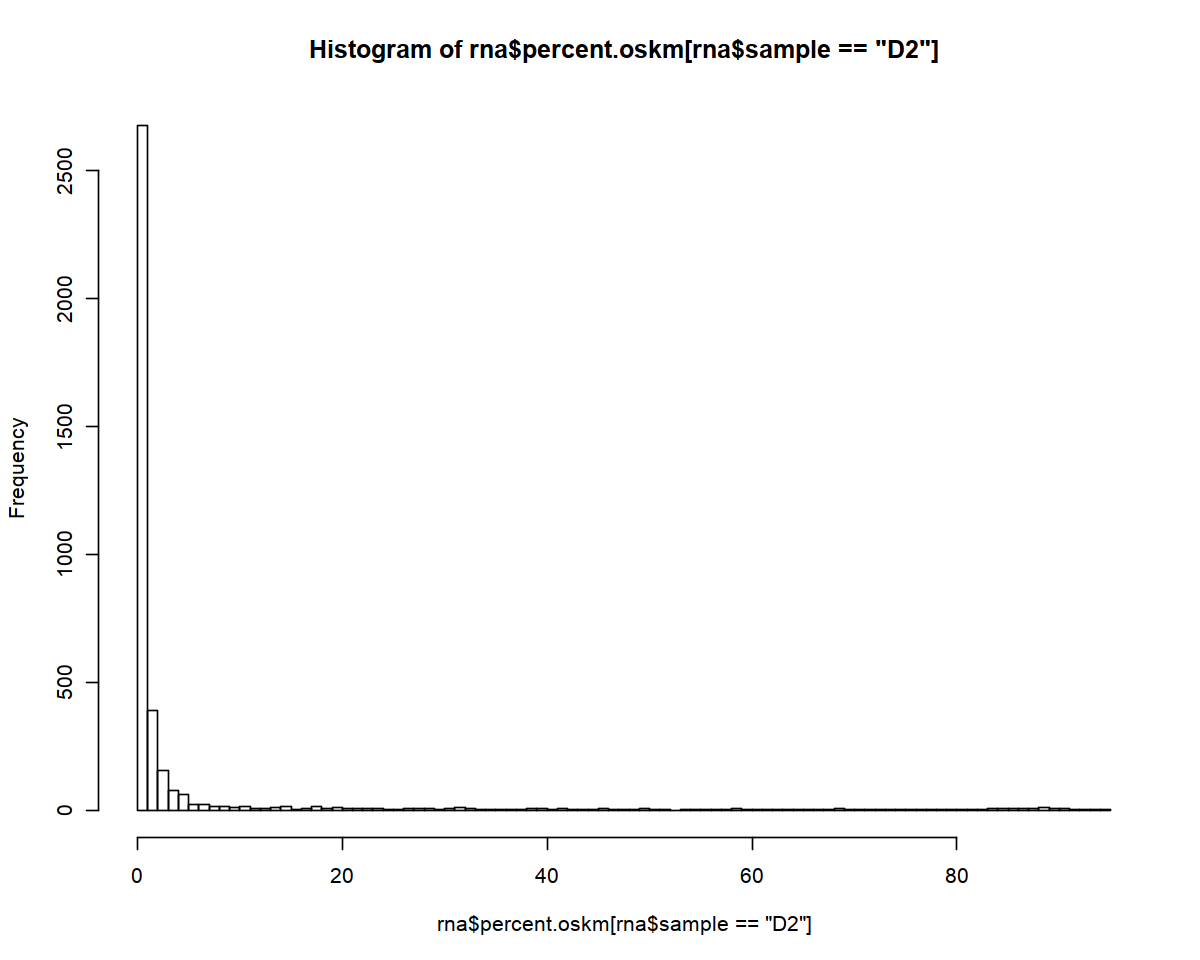

In [28]:
hist(rna$percent.oskm[rna$sample=="D2"], breaks=100)
mean(rna$percent.oskm[rna$sample=="D2"] > 50)

In [29]:
md = rna@meta.data
conds = md$nFeature_RNA > 200 & md$percent.mt <15 & md$percent.oskm <50 & md$nCount_RNA > 2000 & md$nCount_RNA < 1e5 
sum(conds)
table(md$sample[conds])

[1] 73065


   D0   D10   D12   D14    D2    D4    D6    D8  iPSC 
11521 12480  8635  9105  2959  6263  9561  6560  5981 

In [30]:
select_bool = rep(0, ncol(rna))
select_bool[conds] = 1
rna[['selected']]= select_bool

In [31]:
# rna_subset <- subset(rna, subset = nFeature_RNA > 200 & nFeature_RNA < 5000 & percent.mt < 10)
rna_subset = subset(rna, subset = selected==1)

In [32]:
table(rna_subset@meta.data$sample)


   D0   D10   D12   D14    D2    D4    D6    D8  iPSC 
11521 12480  8635  9105  2959  6263  9561  6560  5981 

## DoubletFinder

In [33]:
doublets = c()

# TODO: technically pK needs to be optimised per sample [need to code that in]
for (d in DAYS) {
    rna_sample = subset(rna_subset, subset = sample==d)
    
    rna_sample <- NormalizeData(rna_sample)
    rna_sample <- FindVariableFeatures(rna_sample, selection.method = "vst", nfeatures = 2000)
    all.genes <- rownames(rna_sample)
    rna_sample <- ScaleData(rna_sample, features = all.genes)
    rna_sample <- RunPCA(rna_sample, features = VariableFeatures(object = rna_sample))
    rna_sample <- RunUMAP(rna_sample, dims = 1:10)
    
    nExp_poi <- round(0.15*ncol(rna_sample)) # 15% stringent (?)
    rna_sample <- doubletFinder_v3(rna_sample, PCs = 1:10, pN = 0.25, pK = 0.01, nExp = nExp_poi, reuse.pANN = FALSE, sct = FALSE)
    
    doublets = c(doublets, rownames(rna_sample@meta.data)[rna_sample@meta.data[, grep("DF.classifications", colnames(rna_sample@meta.data))[1]]=="Doublet"])
}

Centering and scaling data matrix

PC_ 1 
Positive:  FTH1, NUPR1, FTL, NEAT1, MFAP4, CEBPD, CLU, DCN, TGFBI, PRKG1 
	   SOX4, PTGDS, SQSTM1, MALAT1, COL4A5, APOE, BMP4, PDE5A, PDGFD, PLPP3 
	   LAMA4, ANTXR1, LXN, SGCD, ABCC4, QSOX1, PDZRN3, SOX5, FGF7, MYLK 
Negative:  CENPF, UBE2C, HMGB2, TOP2A, H2AFZ, MKI67, CKS1B, TYMS, ANLN, MAD2L1 
	   PBK, UBE2T, RRM2, PRC1, BIRC5, UBE2S, KIF20B, TPX2, ASPM, DIAPH3 
	   ZWINT, CENPE, SMC4, CDK1, NUSAP1, GTSE1, SPC25, CCNB1, CKS2, H2AFX 
PC_ 2 
Positive:  STMN1, PTTG1, CCNB1, TUBA1B, PFN1, TUBB4B, PTMA, CDC20, CCNB2, CDKN3 
	   HMGA1, TUBA1C, JPT1, KIF20A, HMGN2, BIRC5, HMGB3, CDCA3, ARL6IP1, LDHA 
	   DLGAP5, RAN, CRABP2, CENPW, RPS27L, HMGB1, DDX39A, PHF19, PIMREG, TROAP 
Negative:  FAM155A, LPP, THSD4, MAGI2, MACF1, SGIP1, EXT1, PRKG1, TRIO, PARD3B 
	   VCL, MALAT1, PALM2-AKAP2, DLC1, CRIM1, BICC1, ASAP1, ZEB1, COL4A1, TMTC1 
	   RHOBTB3, PALLD, MYO10, RAI14, RBMS3, SAMD4A, COL4A2, MIR4435-2HG, ANO4, SMURF2 
PC_ 3 
Positive:  DCN, BMP4, TGFBI,

[1] "Creating 3840 artificial doublets..."
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."
[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Computing pANN..."
[1] "Classifying doublets.."


Centering and scaling data matrix

PC_ 1 
Positive:  TNNT1, COL9A3, FSTL3, FBXO2, EEF1A2, PTP4A3, HBA1, HBA2, S100P, ARC 
	   CALY, CNFN, TNNC1, ASCL2, ADAM8, SCNN1D, KLK1, PSTPIP1, DMKN, SLC6A8 
	   SBSN, MKNK2, HES4, SOX15, CDH15, IL11, RASGRP2, KISS1R, CLIC3, TNNI3 
Negative:  MT2A, COL3A1, GPC6, THY1, EXT1, DLC1, SEMA3A, NCL, PLCB1, ARID5B 
	   BNC2, NRP1, DCBLD2, FAM155A, FRMD4A, HMGA2, ARHGAP18, SOX5, ZFP36L1, LDB2 
	   PRKG1, MYO10, RBMS3, MYL9, SFRP1, CTHRC1, IL1RAPL1, PDGFRA, SOX4, ROBO1 
PC_ 2 
Positive:  COL1A2, COL1A1, COL6A3, FN1, CTHRC1, SMAD3, MYLK, ZFP36L1, TAGLN, MT2A 
	   IFITM3, TGFBI, CAMK2N1, IFI6, IGFBP4, MYL9, TMEM158, PRR16, FOS, ISG15 
	   SERPINE1, PLAU, RND3, JUNB, TNC, DCN, C1R, DUSP1, RNF213, PDGFRA 
Negative:  ODC1, HS3ST5, FERMT1, KCNQ5, MAP2, NIPA1, MET, GLUL, TFB1M, MYC 
	   PAWR, GAL, POU5F1, DOK6, HMCES, DANCR, JAKMIP2, CHST2, RNF125, DDX10 
	   TMC6, CERS6, ST8SIA4, THRB, ARGFX, IFRD1, CAPRIN2, KCTD12, AC002463.1, PCDH10 
PC_ 3 
Positive:  DOK6, MAP4

[1] "Creating 986 artificial doublets..."
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."
[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Computing pANN..."
[1] "Classifying doublets.."


Centering and scaling data matrix

PC_ 1 
Positive:  HBA1, HBA2, FBXO2, DMKN, S100P, FSTL3, SLURP2, TNNI3, CKM, COL9A3 
	   CNFN, CDH15, LY6D, PSTPIP1, SCNN1D, ABCA7, KISS1R, ARC, EEF1A2, SBSN 
	   CLIC3, MAB21L4, SLC17A7, TRH, COL11A2, COMP, KLK1, SLC9A3, TNNT1, GABRD 
Negative:  ROBO1, DOK6, ARHGAP18, MAP4K3, LYPLAL1-DT, CALB1, MEIS2, LINC02582, AC002463.1, CHST2 
	   PCDH10, KIAA1217, HS3ST5, THSD7A, DANCR, KCNK2, PCDH9, L1TD1, MGAT4C, CERS6 
	   SUPT3H, PCDH15, FLRT2, KCNQ5, GYPC, RNF125, CD36, AC021231.1, ARGFX, LSAMP 
PC_ 2 
Positive:  HS3ST5, CALB1, LINC02582, AC002463.1, AC099520.1, RNF125, ARGFX, AC021231.1, FERMT1, L1TD1 
	   POU5F1, MIR302CHG, ODC1, DOK6, LYPLAL1-DT, LIM2, CD24, KCNQ5, CD36, PCDH10 
	   LPCAT3, MAP4K3, FIRRE, PLAAT3, ANK2, ST6GAL1, KIAA1217, ARHGAP18, CERS6, SYNE1 
Negative:  COL1A1, COL1A2, COL6A3, FN1, TGFBI, CTHRC1, TIMP1, MYL9, MT2A, BGN 
	   TAGLN, ZEB1, TNC, IER3, PTN, PDE5A, NTM, PRR16, TMEM158, IFITM3 
	   PLAU, IFI6, C1R, PDGFRA, POSTN, ISG15, STC1,

[1] "Creating 2088 artificial doublets..."
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."
[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Computing pANN..."
[1] "Classifying doublets.."


Centering and scaling data matrix

PC_ 1 
Positive:  COL1A1, COL6A2, COL1A2, COL6A3, SPARC, TIMP1, TGFBI, CTHRC1, FN1, SMAD3 
	   IER3, PDGFRB, COL3A1, BGN, CD82, LOXL2, PLAU, OLFM2, EDNRA, ZEB1 
	   STC1, HLA-B, COL12A1, IFI6, BICC1, SH3RF3, ISG15, EGFR, MYL9, COL8A1 
Negative:  HS3ST5, LINC02582, ANK2, AC021231.1, CD24, POU5F1, DPH6, MIR302CHG, CD36, ST6GAL1 
	   FIRRE, ANO4, RNF125, LINC00678, AC099520.1, L1TD1, MGAT4C, PYGB, DOK6, ENPP1 
	   SOX2, LYPLAL1-DT, THEMIS, FBN2, FERMT1, CD70, AC007326.5, PIR, SYNE1, SCARA5 
PC_ 2 
Positive:  JAKMIP2, NKAIN2, SUPT3H, AC073050.1, NRCAM, EDIL3, PKN2-AS1, LEPR, IL31RA, ABCD3 
	   MBNL3, CDH2, LRRC69, AC002463.1, LINC00882, AC116362.1, COL11A1, AC093298.2, PCLO, CCNO 
	   CNKSR2, PRICKLE1, SYNE1, ARRDC3-AS1, LINC00437, LINC01088, SCUBE2, ZFHX4, ANO3, APBA1 
Negative:  KRT18, PPP1R14A, TNNT1, CDA, KRT8, CD52, IGFBP6, TTYH1, CD70, AQP3 
	   UTF1, UPP1, OLFML3, RNASE1, SPINT2, ESRG, CD83, PI16, SNCG, CDHR1 
	   PCAT14, TNFSF9, TM4SF1, S100A4, SE

[1] "Creating 3187 artificial doublets..."
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."
[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Computing pANN..."
[1] "Classifying doublets.."


Centering and scaling data matrix

PC_ 1 
Positive:  COL1A1, TGFBI, COL1A2, TIMP1, COL3A1, ID3, STC1, IER3, PLAU, GLIS3 
	   DCN, ISG15, EDNRA, MT2A, NTM, IFI6, TMEM158, OLFM2, MME, PRR16 
	   EREG, PAPPA, RFX8, COL5A3, CYGB, SGIP1, CXCL8, TNC, MYL9, ARHGAP24 
Negative:  LINC02582, ANK2, CALB1, HS3ST5, POU5F1, CD24, L1TD1, PLAAT3, FIRRE, PYGB 
	   AC021231.1, LIM2, ST6GAL1, SOX2, RNF125, MET, MIR302CHG, KIAA1217, AC007326.5, OLFML3 
	   CD70, PHKA1, DPPA4, ANO4, ARGFX, TNFSF9, LINC00678, FERMT1, KRT8, AC099520.1 
PC_ 2 
Positive:  NKAIN2, JAKMIP2, ROBO1, AC093298.2, ZFHX4, LRRC7, LYPLAL1-DT, ARRDC3-AS1, DOK6, DLG2 
	   THSD7A, SUPT3H, PCDH9, SYNE1, LSAMP, AC073050.1, DACH1, PCDH15, PCLO, LEPR 
	   MBNL3, KCNK2, PRKG1, MAP4K3, GRIP1, COL11A1, CDH2, MGAT4C, AC002463.1, APBA1 
Negative:  UTF1, IGFBP6, PPP1R14A, TNNT1, SPINT2, AIF1L, CDA, PCAT14, ESRG, NANOG 
	   KRT18, AQP3, DSP, VWA1, ASRGL1, ALPL, S100A16, KRT19, HLA-DQB1, TDGF1 
	   NGEF, TUBB2A, CD9, DYSF, TTYH1, TUBB2B, CSTB, TNNI3, 

[1] "Creating 2187 artificial doublets..."
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."
[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Computing pANN..."
[1] "Classifying doublets.."


Centering and scaling data matrix

PC_ 1 
Positive:  LGALS1, COL1A1, COL6A3, COL1A2, TPM2, B2M, SPARC, TGFBI, FN1, CAV1 
	   COL6A2, CTHRC1, TUBA1A, MYL9, TSPO, TAGLN, LRRC17, TPM1, ZEB1, COL3A1 
	   CALD1, NTM, PRRX1, PXDN, COL6A1, DCBLD2, INHBA, TIMP1, WNT5A, MICAL2 
Negative:  MT1X, POU5F1, L1TD1, MIR302CHG, CALB1, AK4, PPP1R14A, LIM2, PLAAT3, LINC02582 
	   HS3ST5, KAZN, FGD4, ANK2, MT1G, PDZRN3, TUBB4A, AC021231.1, PCAT14, GSTP1 
	   C19orf33, UTF1, ST6GAL1, LINC00678, KRT8, SEMA6A, ARGFX, AC009055.2, SPINT2, TTYH1 
PC_ 2 
Positive:  DTNA, IL1RAPL1, PCDH7, PCDH15, ROBO1, TOX, SNTG1, THSD7A, PCDH9, GSN 
	   MGAT4C, AC002463.1, NR1H4, CNTN1, LYPLAL1-DT, PCLO, COL5A2, IGFBP5, PMP22, NEAT1 
	   LRRC7, DOK6, TCF7L2, KITLG, LDB2, DIO2, NRG1, MEF2C, SULF1, LDLRAD4 
Negative:  MT2A, MT1E, MT1G, SPINT2, TDGF1, NLRP7, TUBB2A, UTF1, EPCAM, AC009055.2 
	   MT1H, MT1F, FBP1, AC022784.2, TTYH1, TNNT1, LEFTY2, NODAL, DAB1, APOE 
	   ALPL, CDH1, AIF1L, ASRGL1, AC064802.1, MX1, PRUNE2, ESRP1, SEMA

[1] "Creating 4160 artificial doublets..."
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."
[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Computing pANN..."
[1] "Classifying doublets.."


Centering and scaling data matrix

PC_ 1 
Positive:  MT1X, UTF1, ASRGL1, POU5F1, AC009055.2, ESRG, AK4, MT1G, LIM2, SEMA6A 
	   FGD4, PLAAT3, NANOG, SPINT2, L1TD1, XACT, TDGF1, TUBB4A, DMD, LINC00678 
	   LINC02582, TTYH1, VSIG10, AGL, AC011447.3, PCAT14, WNK2, MIR302CHG, GRID2, RNF125 
Negative:  B2M, COL1A2, LGALS1, COL1A1, TPM2, COL6A3, COL3A1, SPARC, ZEB1, FN1 
	   MALAT1, CHN1, COL5A2, EMILIN1, COL6A1, TGFBI, BGN, TIMP1, TSPO, CTHRC1 
	   COL12A1, COL6A2, EMP1, HLA-B, S100A6, PDGFRB, CALD1, DLC1, NEAT1, MFAP4 
PC_ 2 
Positive:  SAT1, CD82, MMP11, ITGA1, IFI6, SPON2, ADAMTS12, UBASH3B, SERPINE1, IFI27 
	   CTHRC1, EPSTI1, BST2, PDE5A, RGCC, SGIP1, COL6A2, COL5A1, TIMP3, NTM 
	   LOXL2, STAT1, ISG15, SPATA13, LTBP2, NBL1, CAV1, MT1E, TYMP, RAMP1 
Negative:  SNTG1, TOX, PCDH9, ANXA1, SLC22A3, PCDH7, ROBO1, DTNA, THSD7A, SFRP1 
	   PCLO, LDLRAD4, AKR1C3, MAP2, SHROOM4, CAVIN2, MOXD1, FBN2, BRINP3, NDST3 
	   PMP22, MYC, ANGPT1, MGAT4C, CENPP, KRT18, BMPR1B, PCDH15, TENM2, AC002463.1 


[1] "Creating 2878 artificial doublets..."
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."
[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Computing pANN..."
[1] "Classifying doublets.."


Centering and scaling data matrix

PC_ 1 
Positive:  MT1X, MT1G, APOE, NLRP7, SEMA6A, MT1H, HSP90AA1, DLL3, DMD, XACT 
	   TUBB4A, CHODL, EZR, AC027288.1, ZYG11A, DNMT3B, JARID2, FRAT2, RNF125, AC092546.1 
	   TERF1, AC005062.1, TBCD, RESF1, ACOXL, UPP1, AP003066.1, AC011476.3, AL354821.1, LRRTM4 
Negative:  COL1A2, COL6A3, B2M, COL1A1, COL3A1, BGN, FN1, COL6A1, COL5A2, TGFBI 
	   TIMP1, HLA-B, ZEB1, EMILIN1, COL6A2, TPM2, MMP2, FKBP10, SPARC, S100A6 
	   COL4A1, POSTN, IGFBP7, COL12A1, COL4A2, EMP1, LGALS1, MFAP4, COL5A1, TSPO 
PC_ 2 
Positive:  PDLIM1, TIMP3, CTHRC1, IFI6, INHBA, RAMP1, C11orf96, SPON2, CD82, MT1E 
	   SERPINE1, LUM, MT2A, TAGLN, TNFRSF12A, ADAMTS12, COL8A1, MICAL2, MYL9, APOE 
	   PHLDA2, ISLR, HOPX, PDGFRB, MMP11, BST2, SGIP1, MT1H, LITAF, IGFBP3 
Negative:  PCDH7, PCDH9, FBN2, NFIA, TOX, ROBO1, SNTG1, RBMS3, TENM2, SLC22A3 
	   ZFHX3, LDLRAD4, AC002463.1, CAVIN2, MEOX2, AKR1C3, AKR1C1, ASXL3, NLGN1, SHROOM4 
	   PURPL, BTNL9, ANXA1, PRSS12, HS3ST5, BMPR1B, PDGFC, 

[1] "Creating 3035 artificial doublets..."
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."
[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Computing pANN..."
[1] "Classifying doublets.."


Centering and scaling data matrix

PC_ 1 
Positive:  XACT, RIMS2, AL157778.1, LINC01090, KIAA0825, ANK2, AQP4-AS1, ROBO2, GPC6, TMEM132D 
	   MIR924HG, FAT3, AC093879.1, GALNT17, PCDH11X, FBXL7, ADCY2, NRG3, DLG2, FHIT 
	   RYR2, IMMP2L, AL513166.1, LINC01194, LINC01162, AC068616.2, SLC2A13, NRXN1, LINC01362, KCNQ1OT1 
Negative:  RPS4X, ACTG1, TUBB, TUBA1B, TPI1, H2AFZ, CFL1, HSP90AA1, SLC25A5, SET 
	   MARCKSL1, DYNLL1, PRDX6, FABP5, KRT18, JPT1, NDUFB11, KDELR1, UBE2S, CYCS 
	   CRABP1, TUBA1C, HNRNPAB, UBC, IGFBP2, CKS1B, TUBA1A, HMGB3, HSPA8, YWHAB 
PC_ 2 
Positive:  AQP4-AS1, AC093879.1, LINC01362, AC068616.2, DEC1, GLRA2, AC027288.3, SPOCK3, STPG2-AS1, GRM7-AS3 
	   AC080068.1, AC012501.2, AC092640.1, LINC01828, AC114930.1, LINC01098, NPSR1-AS1, AC023051.1, CCDC26, GNA14-AS1 
	   AP000943.2, SLC1A4, IGF1, IL1RAPL2, HIF1A-AS3, AL118523.1, TTN, MROH9, AL512452.1, LINC01829 
Negative:  MKI67, EIF3A, MT-ND2, TPX2, CENPF, MT-ND5, HSP90B1, SOX2, KDELR1, HNRNPAB 
	   DSP, MT-CYB, CHD4, 

[1] "Creating 1994 artificial doublets..."
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."
[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Computing pANN..."
[1] "Classifying doublets.."


In [34]:
length(unique(doublets))

[1] 10959

In [35]:
head(doublets)

[1] "AAACCCACAACTCGAT-1" "AAACCCACACGACAGA-1" "AAACGAATCCACGTCT-1"
[4] "AAAGGGCAGTTGCCTA-1" "AAAGGGCCACCTGAAT-1" "AAAGGGCCATACATCG-1"

In [36]:
# sweep.res.sample <- paramSweep_v3(rna_sample, PCs = 1:10, sct = FALSE)
# sweep.stats.sample <- summarizeSweep(sweep.res.sample, GT = FALSE)
# bcmvn.sample <- find.pK(sweep.stats.sample)

## Viz

## With doublets

In [37]:
rna_w_doub = rna_subset
    
rna_w_doub <- NormalizeData(rna_w_doub)
rna_w_doub <- FindVariableFeatures(rna_w_doub, selection.method = "vst", nfeatures = 2000)
all.genes <- rownames(rna_w_doub)
rna_w_doub <- ScaleData(rna_w_doub, features = all.genes)
rna_w_doub <- RunPCA(rna_w_doub, features = VariableFeatures(object = rna_w_doub))
rna_w_doub <- RunUMAP(rna_w_doub, dims = 1:10)

Centering and scaling data matrix

PC_ 1 
Positive:  GRID2, DPPA4, ESRG, SEMA6A, L1TD1, XACT, LRRTM4, FGD4, AC009446.1, CECR2 
	   AC009055.2, TDGF1, SNHG14, AC005062.1, DNMT3B, AL354821.1, TRIM71, AL691420.1, RBM47, AL157778.1 
	   LINC00678, AC011447.3, TUBB2B, AC104041.1, AL117378.1, VASH2, SPINT2, AC064802.1, MIR302CHG, JARID2 
Negative:  COL1A1, TIMP1, COL6A3, COL1A2, CD99, CAV1, COL3A1, FN1, SPARC, TGFBI 
	   HLA-B, CTHRC1, MYL9, NUPR1, MT2A, ARID5B, TMEM158, IGFBP4, DCN, IER3 
	   TAGLN, PHLDA2, FTL, IGFBP6, NEAT1, SQSTM1, SERPINE1, TNC, CAMK2N1, PLAU 
PC_ 2 
Positive:  LINC02582, CALB1, LIM2, CD70, MYC, CHST2, AC021231.1, MT1X, ARGFX, AC099520.1 
	   PYGB, AC105460.1, TNFSF9, C19orf33, TUBB4A, PIK3AP1, MT1G, RNF125, SCARA5, LINC00378 
	   TTYH1, PCAT14, THEMIS, AC007326.5, AC084198.2, CD83, HPGD, PDZRN3, UPP1, FERMT1 
Negative:  NLGN4X, GALNT17, TMEM132D, SHISA9, SNTG2, DLGAP1, MAGI2, PTPRZ1, NRG3, KHDRBS2 
	   DPP10, RMST, ROR1, AC022140.1, CNTNAP2, TMEM132B, RIMS2, FRAS1, U91

In [38]:
rna_w_doub

An object of class Seurat 
32642 features across 73065 samples within 1 assay 
Active assay: RNA (32642 features, 2000 variable features)
 2 dimensional reductions calculated: pca, umap

In [39]:
rna_w_doub[['doublet']] = rownames(rna_w_doub@meta.data) %in% doublets

In [40]:
plot_df <- data.frame(pc1=data.frame(Embeddings(rna_w_doub, reduction='umap'))$UMAP_1,
                 pc2=data.frame(Embeddings(rna_w_doub, reduction='umap'))$UMAP_2,
                 sample=rna_w_doub@meta.data$sample)
plot_df = plot_df[sample(dim(plot_df)[1]), ]

by_day <- ggplot(plot_df) +
geom_point(aes(x=pc1, y=pc2, color=factor(sample, levels=DAYS)), stroke=0, size=.5) +
theme_classic() +
scale_color_manual(values=day_config$colour) +
xlab("UMAP 1") + ylab("UMAP 2") +
theme(plot.title = element_text(hjust = 0.5),
      text = element_text(size=12),
      axis.line=element_blank(),
      axis.text.x=element_blank(),
      axis.text.y=element_blank(),
      axis.ticks=element_blank(),
      panel.border = element_rect(colour = "black", fill=NA, size=0.5)) +
guides(colour = guide_legend(title="Day",
     override.aes = list(shape=16, alpha=1, size=4)))

In [41]:
plot_df <- data.frame(pc1=data.frame(Embeddings(rna_w_doub, reduction='umap'))$UMAP_1,
                 pc2=data.frame(Embeddings(rna_w_doub, reduction='umap'))$UMAP_2,
                 doub=rna_w_doub@meta.data$doublet)
plot_df = plot_df[sample(dim(plot_df)[1]), ]

by_doub <- ggplot(plot_df) +
geom_point(aes(x=pc1, y=pc2, color=doub), stroke=0, size=.5) +
theme_classic() +
xlab("UMAP 1") + ylab("UMAP 2") +
theme(plot.title = element_text(hjust = 0.5),
      text = element_text(size=12),
      axis.line=element_blank(),
      axis.text.x=element_blank(),
      axis.text.y=element_blank(),
      axis.ticks=element_blank(),
      panel.border = element_rect(colour = "black", fill=NA, size=0.5)) +
guides(colour = guide_legend(title="Day",
     override.aes = list(shape=16, alpha=1, size=4)))

In [42]:
plot_df <- data.frame(pc1=data.frame(Embeddings(rna_w_doub, reduction='umap'))$UMAP_1,
                 pc2=data.frame(Embeddings(rna_w_doub, reduction='umap'))$UMAP_2,
                 mt=rna_w_doub@meta.data$percent.mt)
plot_df = plot_df[sample(dim(plot_df)[1]), ]

by_mt <- ggplot(plot_df, aes(x=pc1, y=pc2, col=as.numeric(mt))) +
geom_point(stroke=0, size=.5) +
theme_classic() +
scale_color_viridis_c() +
xlab("UMAP 1") + ylab("UMAP 2") +
theme(plot.title = element_text(hjust = 0.5),
      text = element_text(size=12),
      axis.line=element_blank(),
      axis.text.x=element_blank(),
      axis.text.y=element_blank(),
      axis.ticks=element_blank(),
      panel.border = element_rect(colour = "black", fill=NA, size=0.5)) 

In [43]:
library(scales)

In [44]:
plot_df <- data.frame(pc1=data.frame(Embeddings(rna_w_doub, reduction='umap'))$UMAP_1,
                 pc2=data.frame(Embeddings(rna_w_doub, reduction='umap'))$UMAP_2,
                 oskm=rna_w_doub$percent.oskm)
plot_df = plot_df[sample(dim(plot_df)[1]), ]

by_oskm <- ggplot(plot_df, aes(x=pc1, y=pc2, col=as.numeric(oskm))) +
geom_point(stroke=0, size=.5) +
theme_classic() +
scale_color_viridis_c(limits=c(0,10), oob=squish) +
xlab("UMAP 1") + ylab("UMAP 2") +
theme(plot.title = element_text(hjust = 0.5),
      text = element_text(size=12),
      axis.line=element_blank(),
      axis.text.x=element_blank(),
      axis.text.y=element_blank(),
      axis.ticks=element_blank(),
      panel.border = element_rect(colour = "black", fill=NA, size=0.5)) 

In [45]:
plot_df <- data.frame(pc1=data.frame(Embeddings(rna_w_doub, reduction='umap'))$UMAP_1,
                 pc2=data.frame(Embeddings(rna_w_doub, reduction='umap'))$UMAP_2,
                 reads=log10(rna_w_doub$nCount_RNA))
plot_df = plot_df[sample(dim(plot_df)[1]), ]

by_reads <- ggplot(plot_df, aes(x=pc1, y=pc2, col=as.numeric(reads))) +
geom_point(stroke=0, size=.5) +
theme_classic() +
scale_color_viridis_c() +
xlab("UMAP 1") + ylab("UMAP 2") +
theme(plot.title = element_text(hjust = 0.5),
      text = element_text(size=12),
      axis.line=element_blank(),
      axis.text.x=element_blank(),
      axis.text.y=element_blank(),
      axis.ticks=element_blank(),
      panel.border = element_rect(colour = "black", fill=NA, size=0.5)) 

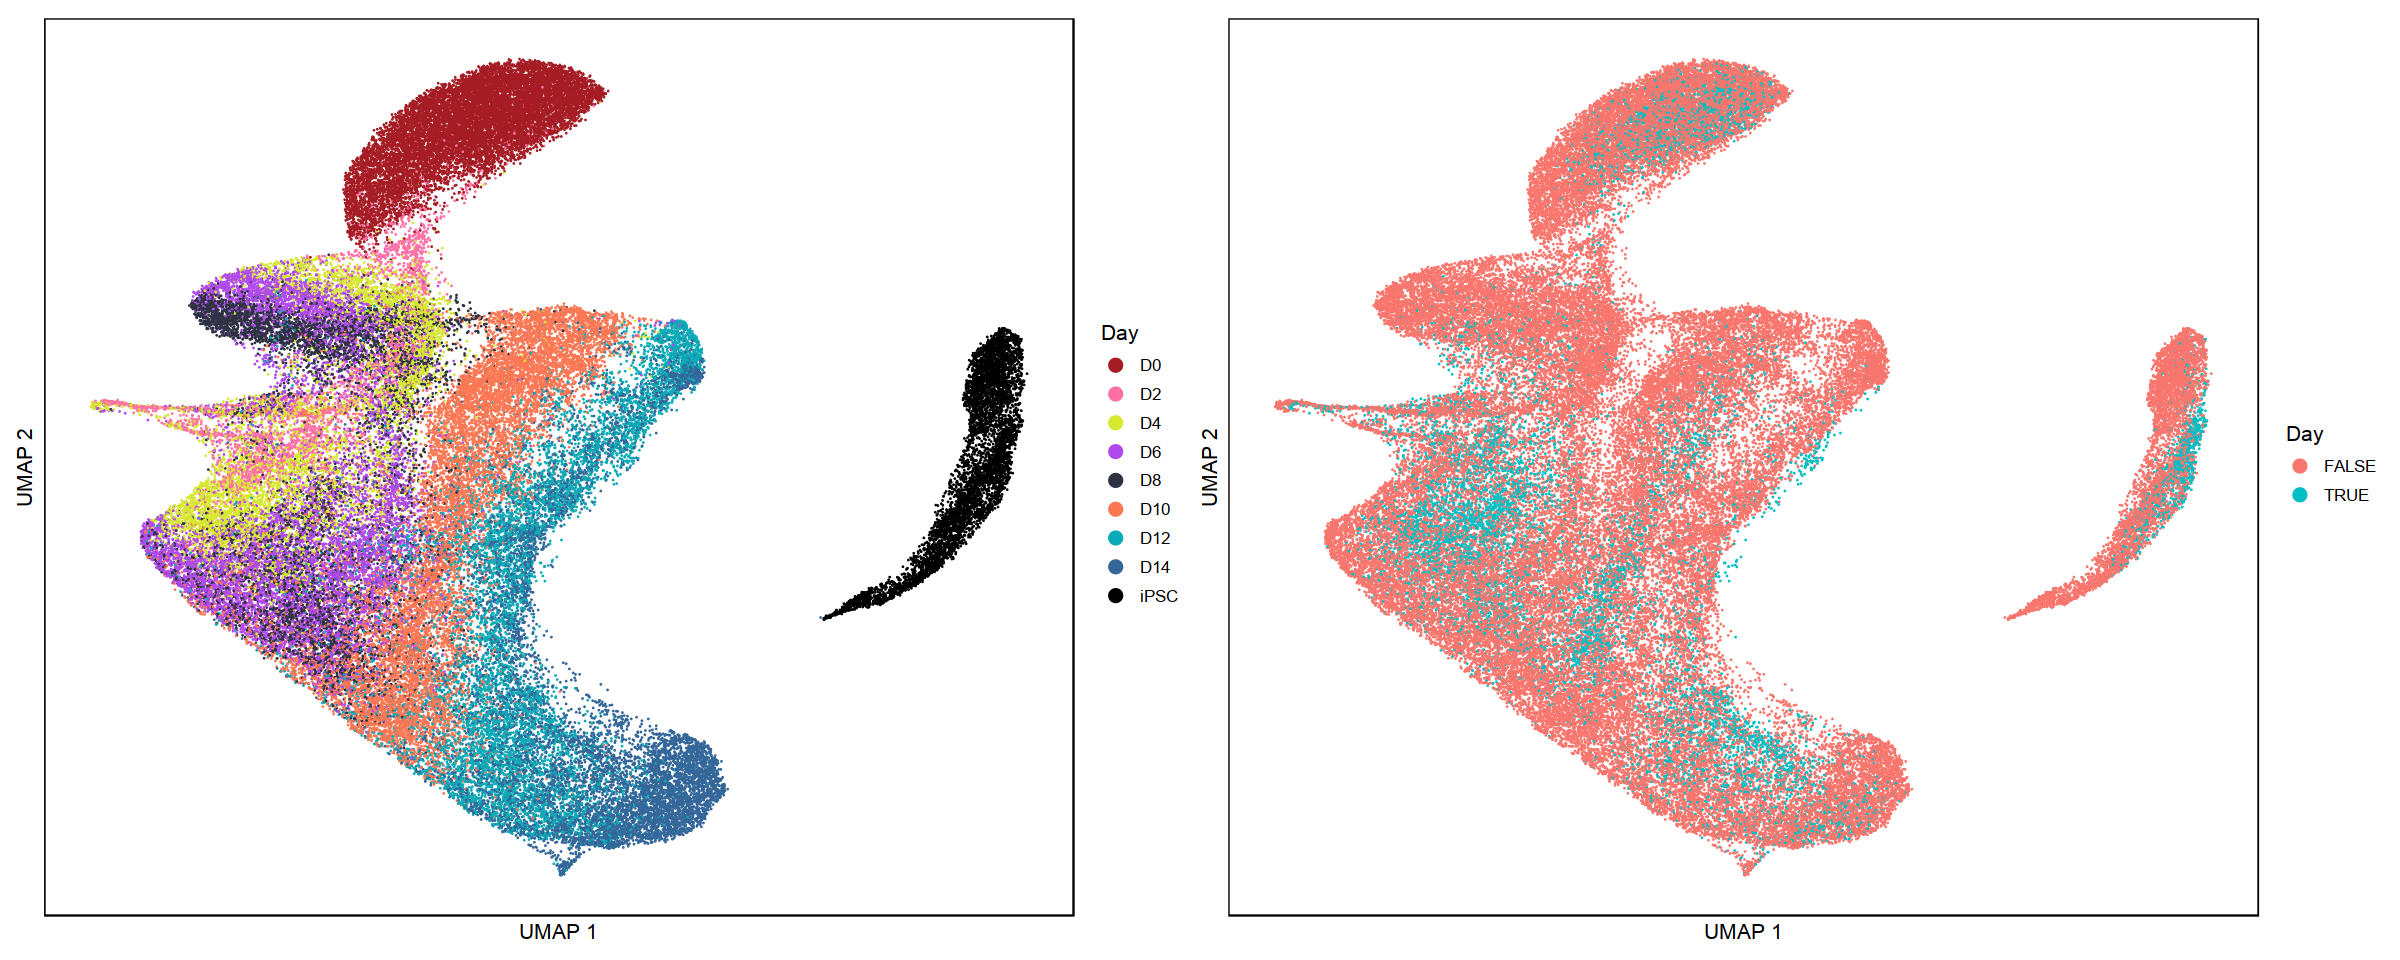

In [46]:
options(repr.plot.width = 20, repr.plot.height = 8)

by_day | by_doub

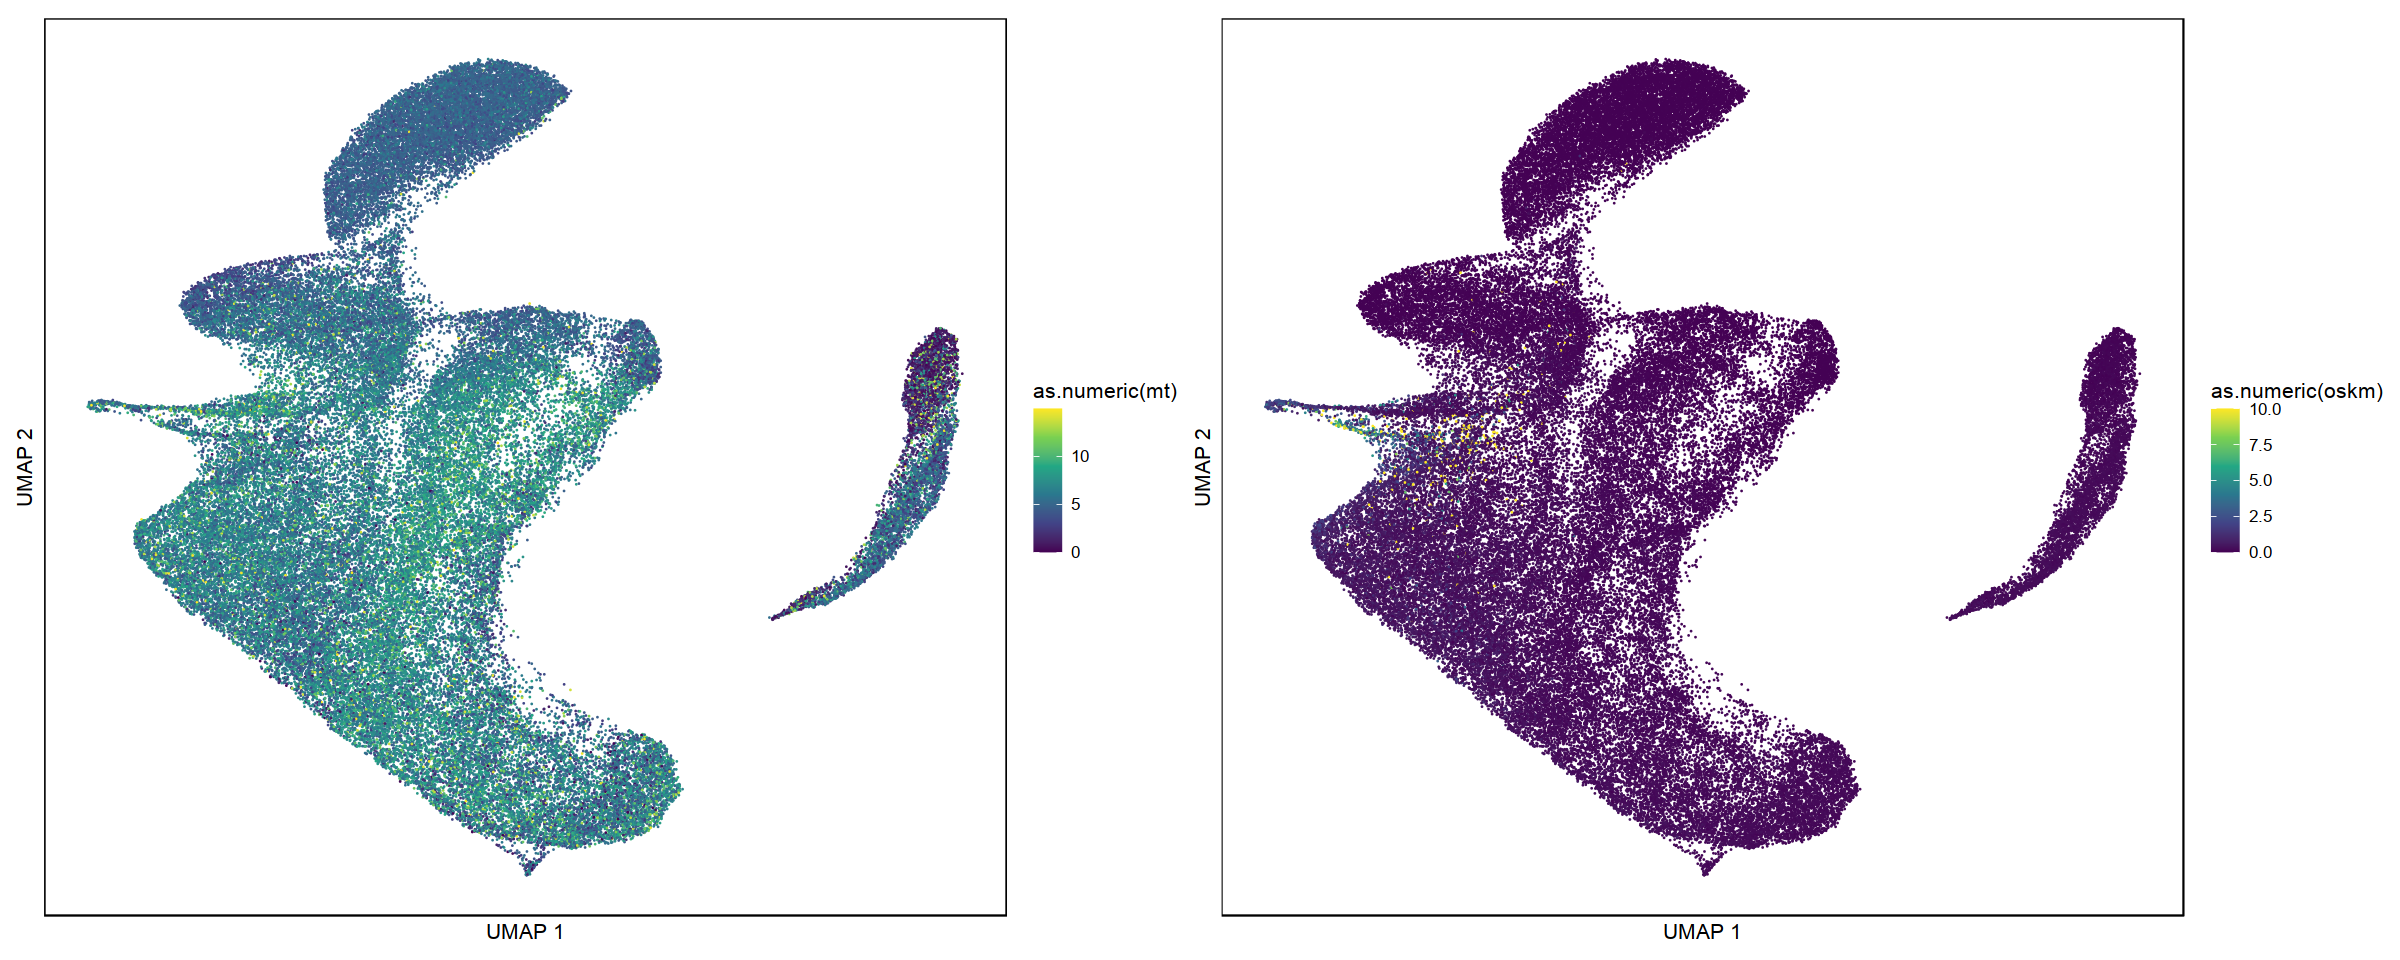

In [47]:
options(repr.plot.width = 20, repr.plot.height = 8)

by_mt | by_oskm

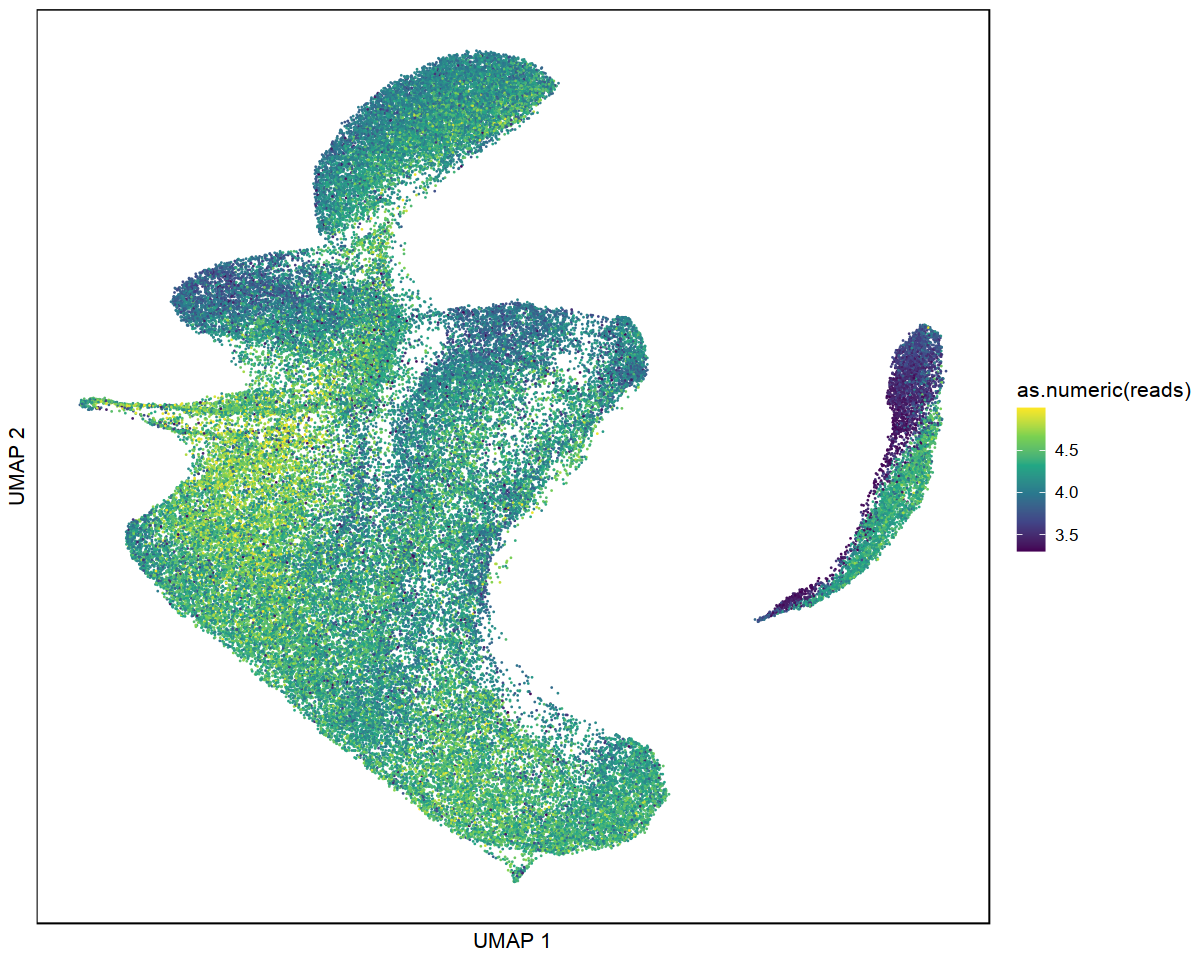

In [48]:
options(repr.plot.width = 10, repr.plot.height = 8)

by_reads

## Without doublets

In [49]:
rna_wo_doub = rna_subset
rna_wo_doub[['doublet']] = rownames(rna_wo_doub@meta.data) %in% doublets

rna_wo_doub = subset(rna_wo_doub, subset = doublet==F)

In [50]:
rna_wo_doub

An object of class Seurat 
32642 features across 62106 samples within 1 assay 
Active assay: RNA (32642 features, 0 variable features)

In [51]:
rna_wo_doub <- NormalizeData(rna_wo_doub)
rna_wo_doub <- FindVariableFeatures(rna_wo_doub, selection.method = "vst", nfeatures = 2000)
all.genes <- rownames(rna_wo_doub)
rna_wo_doub <- ScaleData(rna_wo_doub, features = all.genes)
rna_wo_doub <- RunPCA(rna_wo_doub, features = VariableFeatures(object = rna_wo_doub))
rna_wo_doub <- RunUMAP(rna_wo_doub, dims = 1:10)

Centering and scaling data matrix

PC_ 1 
Positive:  COL1A1, COL6A3, TIMP1, COL1A2, FN1, COL3A1, CAV1, CD99, SPARC, CTHRC1 
	   TGFBI, HLA-B, MYL9, IER3, NUPR1, TAGLN, TMEM158, IGFBP4, FTL, DCN 
	   PHLDA2, MT2A, SERPINE1, SQSTM1, PDGFRB, TNC, PLAU, NEAT1, CAMK2N1, SPON2 
Negative:  DPPA4, L1TD1, SEMA6A, XACT, ESRG, FGD4, GRID2, AC009055.2, LRRTM4, TDGF1 
	   CECR2, AC009446.1, LINC00678, SERINC5, SPINT2, MIR302CHG, SNHG14, UTF1, PLAAT3, TRIM71 
	   ANK2, AC011447.3, AL691420.1, TUBB2B, NANOG, AC005062.1, DNMT3B, CD24, RBM47, KAZN 
PC_ 2 
Positive:  LINC02582, CALB1, MYC, LIM2, CD70, CHST2, AC021231.1, PYGB, ARGFX, AC099520.1 
	   MT1X, AC105460.1, PIK3AP1, TNFSF9, C19orf33, SCARA5, PDZRN3, CD36, THEMIS, TUBB4A 
	   PPP1R14A, FERMT1, MET, LINC00378, CD83, PCAT14, RNF125, TTYH1, AC084198.2, KLF4 
Negative:  NLGN4X, GALNT17, TMEM132D, SNTG2, DLGAP1, SHISA9, AC022140.1, PTPRZ1, NRG3, FRAS1 
	   RIMS2, DPP10, KHDRBS2, RMST, CNTNAP2, GABRB3, ROR1, AC003975.1, TMEM132B, U91319.1 
	   RBFOX1,

In [52]:
plot_df <- data.frame(pc1=data.frame(Embeddings(rna_wo_doub, reduction='umap'))$UMAP_1,
                 pc2= -data.frame(Embeddings(rna_wo_doub, reduction='umap'))$UMAP_2,
                 sample=rna_wo_doub@meta.data$sample)
plot_df = plot_df[sample(dim(plot_df)[1]), ]

by_day <- ggplot(plot_df) +
geom_point(aes(x=pc1, y=pc2, color=factor(sample, levels=DAYS)), stroke=0, size=0.5) +
theme_classic() +
scale_color_manual(values=day_config$colour) +
xlab("UMAP 1") + ylab("UMAP 2") +
theme(plot.title = element_text(hjust = 0.5),
      text = element_text(size=12),
      axis.line=element_blank(),
      axis.text.x=element_blank(),
      axis.text.y=element_blank(),
      axis.ticks=element_blank(),
      panel.border = element_rect(colour = "black", fill=NA, size=0.5)) +
guides(colour = guide_legend(title="Day",
     override.aes = list(shape=16, alpha=1, size=4)))

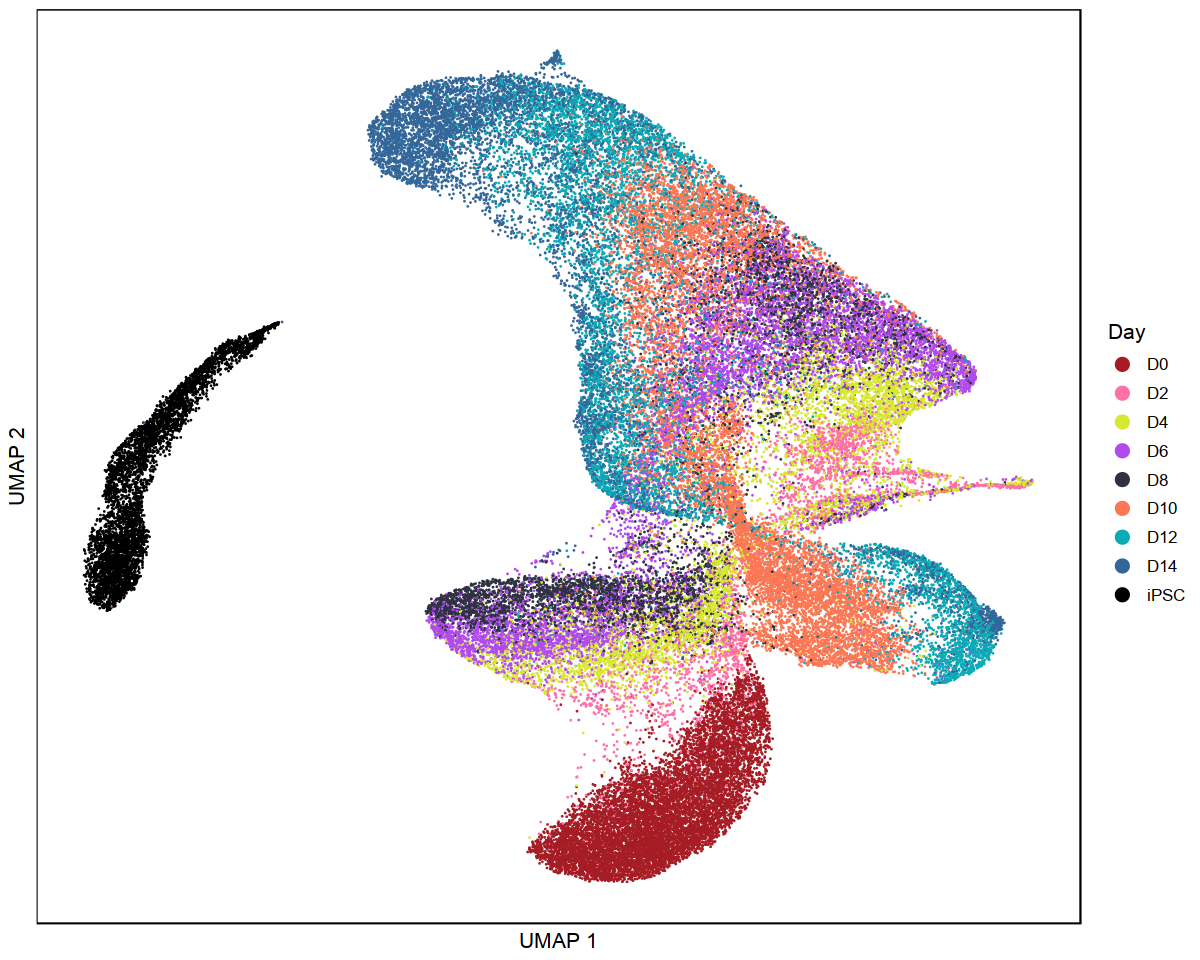

In [53]:
options(repr.plot.width = 10, repr.plot.height = 8)

by_day

In [156]:
# invert 
# rna_wo_doub@reductions$umap@cell.embeddings[,"UMAP_2"] = -rna_wo_doub@reductions$umap@cell.embeddings[,"UMAP_2"]

In [244]:
write.table(rownames(rna_wo_doub@meta.data),
            file='./barcodes/20210722_nFeat200_mt15_oskm50_nCount2000_doub15_pk0.01.txt',
            quote=F,
            row.names=F,
            col.names=F)

[[1]]


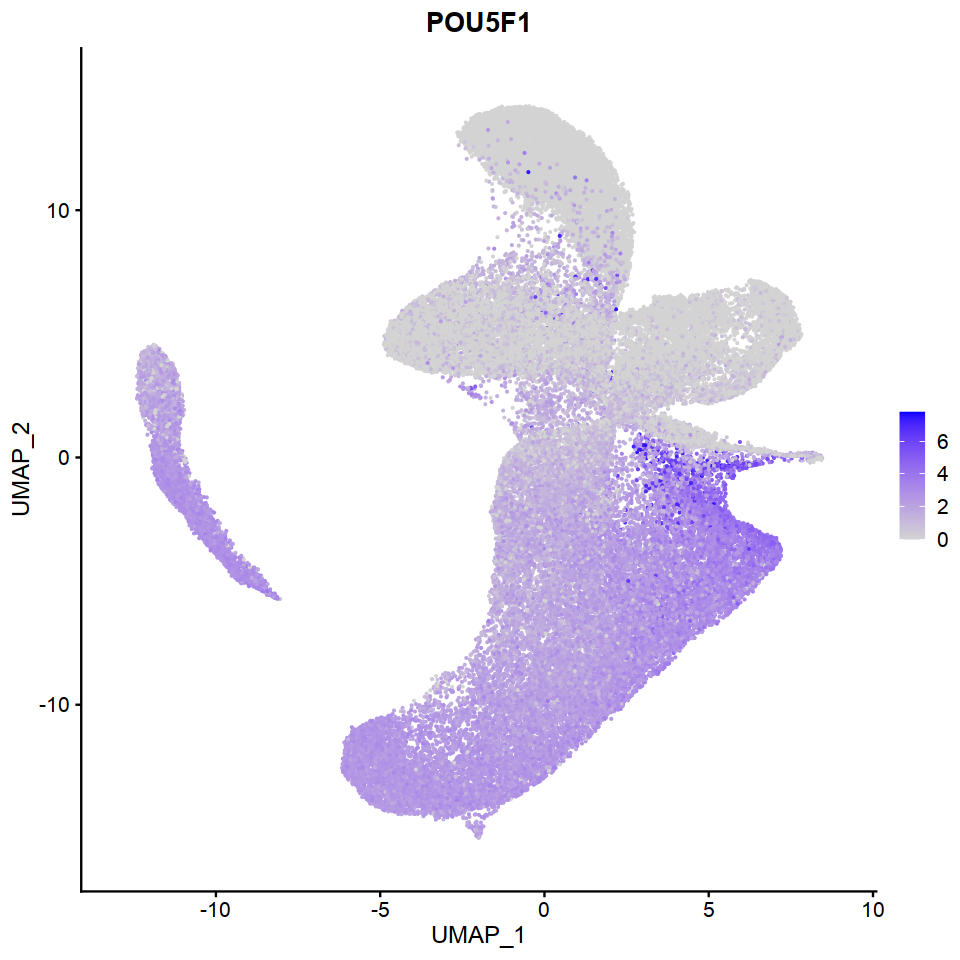

In [54]:
options(repr.plot.width = 8, repr.plot.height = 8)

FeaturePlot(rna_wo_doub, features = c("POU5F1"), reduction = "umap", pt.size = 0.1, combine = FALSE)

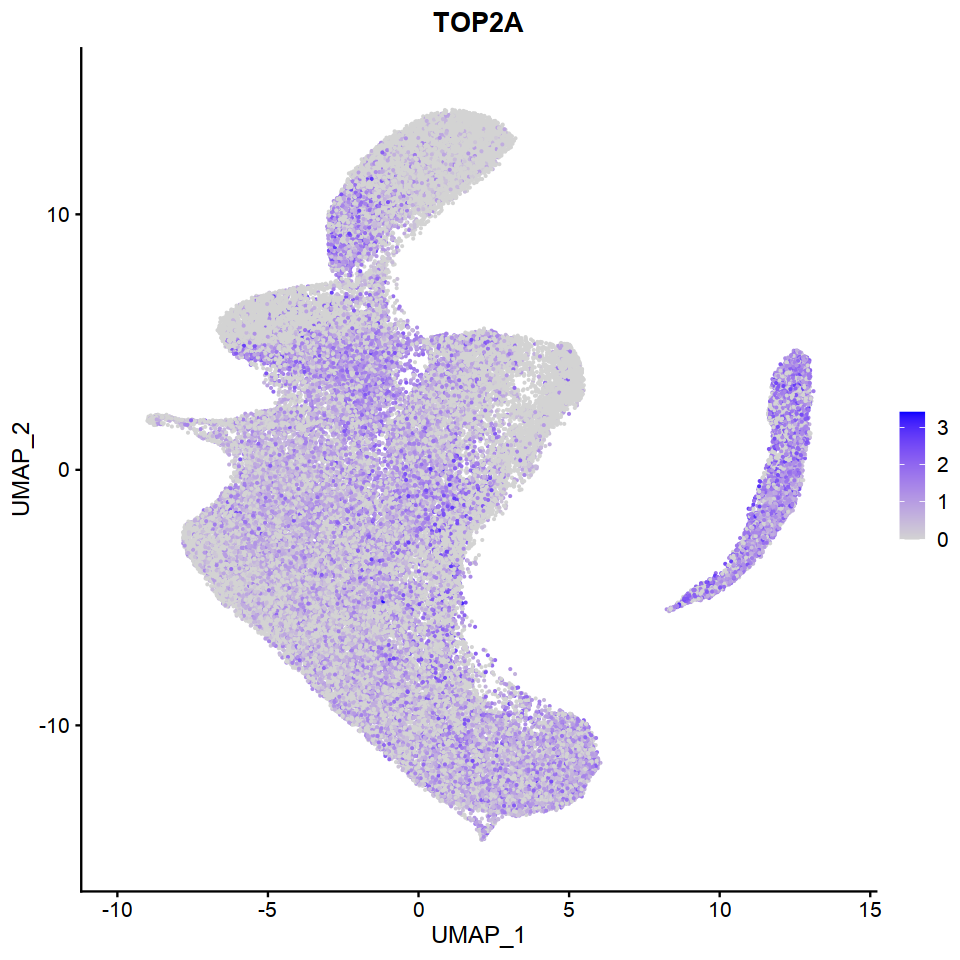

In [55]:
options(repr.plot.width = 8, repr.plot.height = 8)

FeaturePlot(rna_w_doub, features = c("TOP2A"), reduction = "umap", pt.size = 0.1, combine = FALSE)[[1]]

---

In [56]:
sessionInfo()

R version 3.6.3 (2020-02-29)
Platform: x86_64-conda_cos6-linux-gnu (64-bit)
Running under: Ubuntu 18.04.5 LTS

Matrix products: default
BLAS/LAPACK: /users/surag/anaconda3/envs/r36_cran/lib/libopenblasp-r0.3.9.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] grid      stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] scales_1.1.0        KernSmooth_2.23-16  fields_10.3        
 [4] maps_3.3.0          spam_2.5-1          dotCall64_1.0-0    
 [7] DoubletFinder_2.0.3 patchwork_1.0.0     ggplot2_3.3.3      
[10] dplyr_1.0.2         Seurat_3.1.5       

loaded via a namespace (and not attached):
 